In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn import cluster
import sklearn.metrics
from sklearn.metrics.pairwise import pairwise_distances
from scipy.stats import entropy
from numpy.linalg import pinv
import operator

The purpose of this notebook is to create a pipeline for clustering cells based on their equivalence class counts and visualizing the produced labels. First, we define several helpful functions to easily do kmeans, spectral clustering, NMF, t-SNE, and a variety of distance functions (e.g. Shannon-Jensen).

In [70]:
# Functions that are helpful for analysis

# obtain labels via kmeans
def jz_kmeans(X,k,num_iter=50):
    k_means = cluster.KMeans(n_clusters=k,max_iter=num_iter,precompute_distances=True)
    k_means.fit(X)
    labels = k_means.labels_
    return labels

# obtain labels via spectral clustering
def jz_spectral(X,k,D):
    # Compute pairwise distances
    #D = pairwise_distances(X,metric=dist_funct,n_jobs=nj)
    if D[1,1] < 1: D = np.exp(-D**2) # Convert distance to similarity matrix
    spectral = cluster.SpectralClustering(n_clusters=k,affinity='precomputed')
    spectral.fit(D)
    labels = spectral.labels_
    return labels,D

# NMF
def jz_NMF(X,n_topics=9):
    nmf = NMF(n_components=n_topics)
    nmf.fit(X)
    pinv_of_dict=pinv(nmf.components_)
    NMF_rep = np.transpose(pinv_of_dict)*np.transpose(X)
    return np.transpose(NMF_rep)

# obtain two major directions from t-SNE
def jz_tSNE(X):
    tsne = manifold.TSNE(n_components=2, random_state=0);
    X_tsne = tsne.fit_transform(X);
    return X_tsne

# Distance metrics (input: X with m samples, output: m-by-m distance matrix)
def shannon_jensen(p, q):
    m=0.5*p+0.5*q
    p = np.transpose(p[p > 0])
    q = np.transpose(q[q > 0])
    m = np.transpose(m[m > 0])
    return np.sqrt(entropy(m)-0.5*entropy(q)-0.5*entropy(p))

# Plot function with colors corresponding to labels (first two columns of X)
def jz_plot(X,labels):
    unique_labels = np.unique(labels)
    plt.figure(figsize=(15,10))
    for label in unique_labels:
        ind = np.squeeze(labels == label)
        plt.scatter(X[ind,0],X[ind,1],c=np.random.rand(3))
       
#Compute the error rates of two classification scheme.
#Rather than going over m! possibilities where m is the number of classes
#this uses the heuristic of comparing the i th largest cluster of on labeling scheme
#with the i th largest cluster of the other labelling scheme
def compare_labels(label1, label2):
    nplabel1=np.array(label1)
    nplabel2=np.array(label2)
    assert len(label1)==len(label2)
    unique_labels1=np.unique(nplabel1)
    unique_labels2=np.unique(nplabel2)
    
    num_entries1={}
    num_entries2={}
    
    for label in unique_labels1:
        num_entries1[label] = len(nplabel1[nplabel1==label])
    
    for label in unique_labels2:
        num_entries2[label] = len(nplabel2[nplabel2==label])
    
    
    sorted_label1 = sorted(num_entries1.items(), key=operator.itemgetter(1))
    sorted_label2 = sorted(num_entries2.items(), key=operator.itemgetter(1))
    
    difference=0
    for index in xrange(len(sorted_label1)):
         set1= set(np.flatnonzero(nplabel1==sorted_label1[index][0]))
         set2= set(np.flatnonzero(nplabel2==sorted_label2[index][0]))
         difference+=len(set1.symmetric_difference(set2))
    
    return difference/2

First, load the data. We use Zeisel et al.'s 3005 brain cells. There should be 342812 equivalence classes total. (Initial processing with Kallisto already done).

In [78]:
# Load data
with open('/data/SS_RNA_seq/Code/sparse_eq_class.dat', 'rb') as infile:
    X = pickle.load(infile)
truth_9 = np.loadtxt('/data/SS_RNA_seq/Code/clustering_on_reads/metadata/cell_group_num_3005.txt',dtype=str)
truth_47 = np.loadtxt('/data/SS_RNA_seq/Code/clustering_on_reads/metadata/cell_subclass_3005.txt',dtype=str)
truth_tissue = np.loadtxt('/data/SS_RNA_seq/Code/clustering_on_reads/metadata/cell_tissue_3005.txt',dtype=str)

# Sanity checks on dimensions of loaded data:
print np.shape(X)
print len(truth_9)

(3005, 342812)
3005


Running t-SNE on the entire data

In [33]:
# Run t-SNE on original data.
%matplotlib inline
X_tsne = jz_tSNE(X)


First few plots: t-SNE on the data and try a variety of labels provided by Zeisel et al.: 1) 47 labels they generated for all subclasses ("(none)" is also a subclass), 3) tissue where certain cells were extracted.

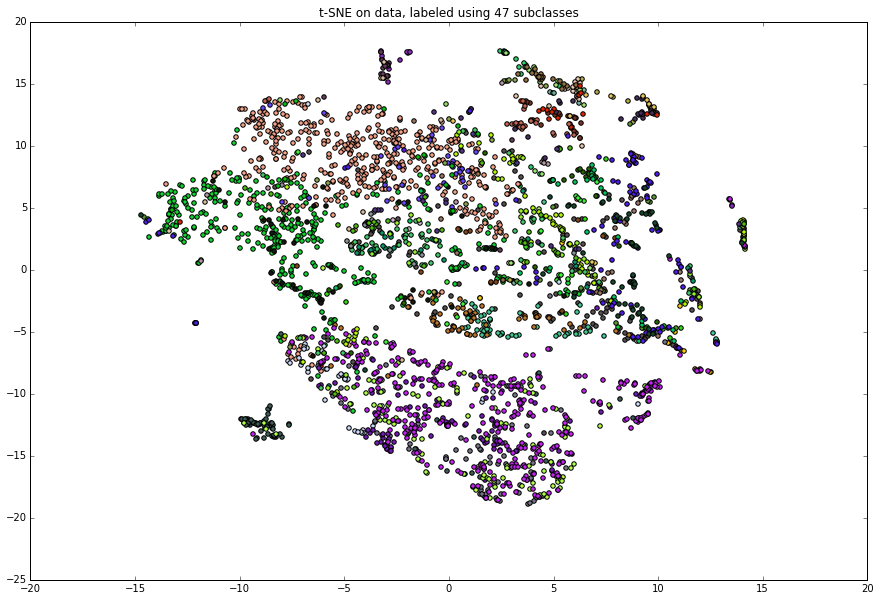

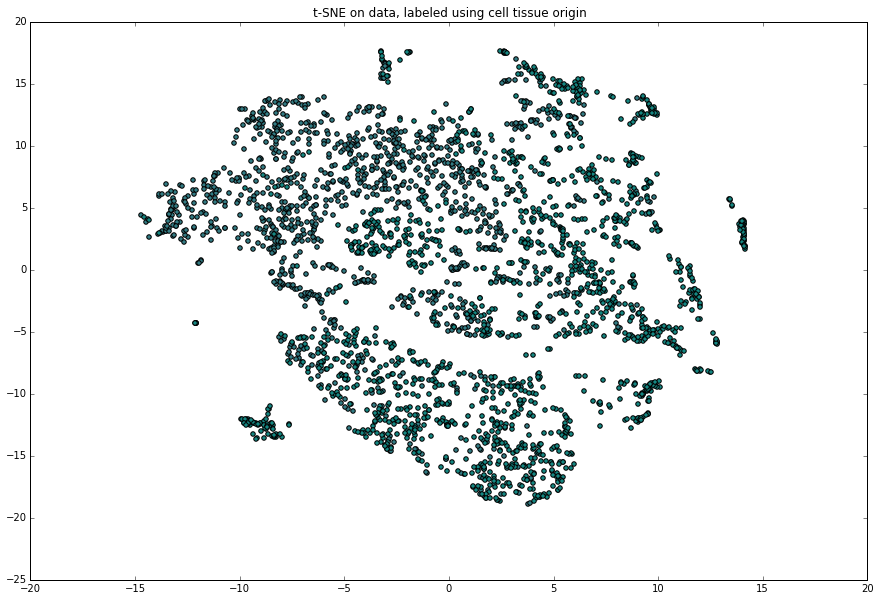

In [34]:
jz_plot(X_tsne,truth_47)
plt.title('t-SNE on data, labeled using 47 subclasses')
jz_plot(X_tsne,truth_tissue)
plt.title('t-SNE on data, labeled using cell tissue origin')

Generate k-means labels for k=9. Compare against the labels the authors generated for the 9 major classes.

In [35]:
#running kmeans with 9 clusters with 50 iterations
k = 9
labels9 = jz_kmeans(X,k)

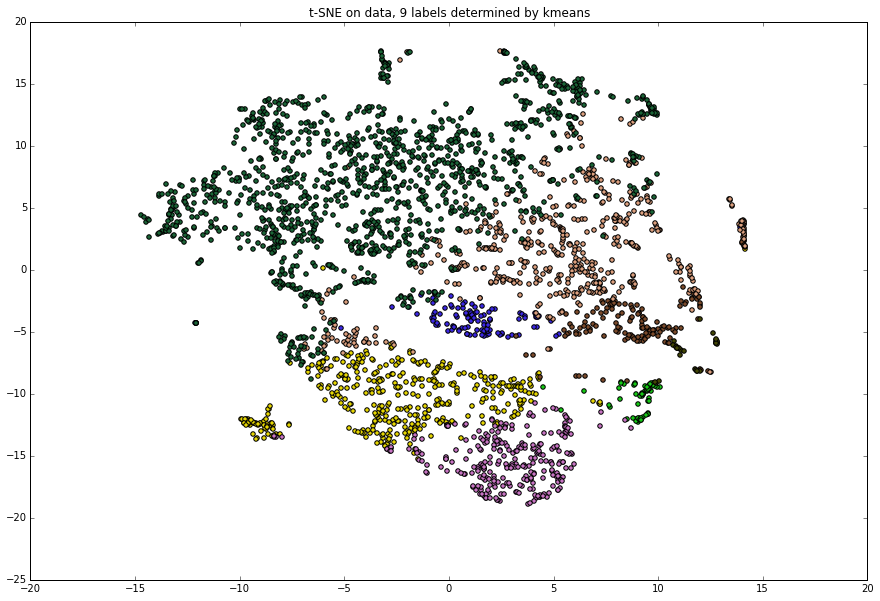

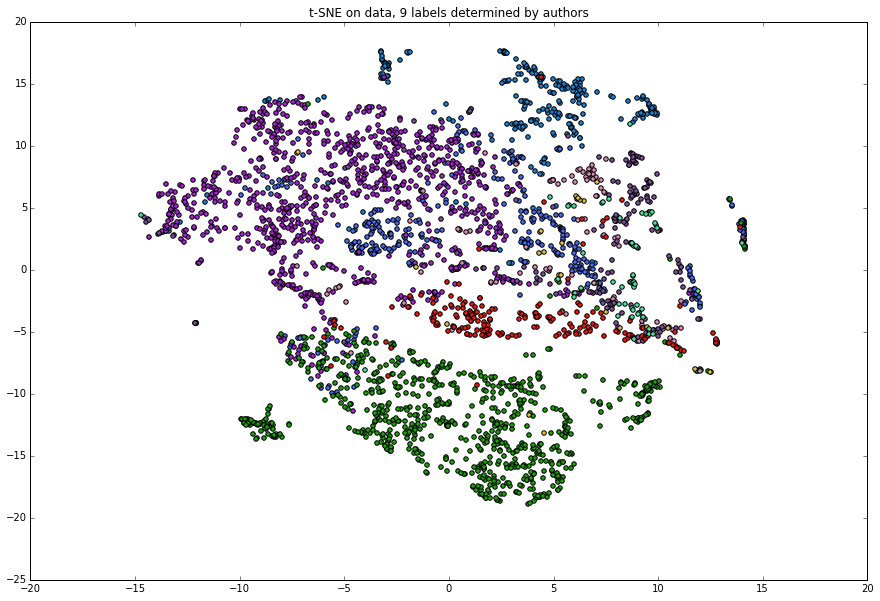

In [36]:
#Plot clusters returned by k-means with k=9
jz_plot(X_tsne,labels9)
plt.title('t-SNE on data, 9 labels determined by kmeans')
jz_plot(X_tsne,truth_9)
plt.title('t-SNE on data, 9 labels determined by authors')

Perform NMF on the dataset

In [38]:
%matplotlib inline
X_NMF = jz_NMF(X,n_topics=2)

We separate the cells of types 1,2, and 3, from those of types 4,5,6,7. The clusters obtained are as shown 

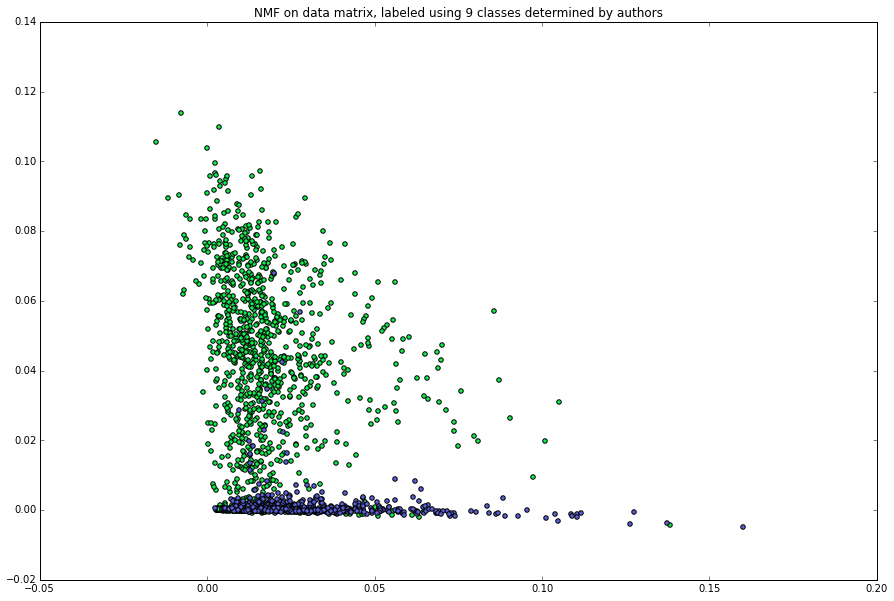

In [84]:
truth_s4=np.loadtxt('/data/SS_RNA_seq/Code/clustering_on_reads/metadata/cell_group_num_3005.txt',dtype=str)
truth_s4[truth_s4<='4']='0'
truth_s4[truth_s4>'4']='1'
jz_plot(X_NMF,truth_s4)
plt.title('NMF on data matrix, labeled using 9 classes determined by authors')

This clustering makes sense when viewing the bar chart from the paper which shows that the first 3 types of cells are much closer than the other 6 classes

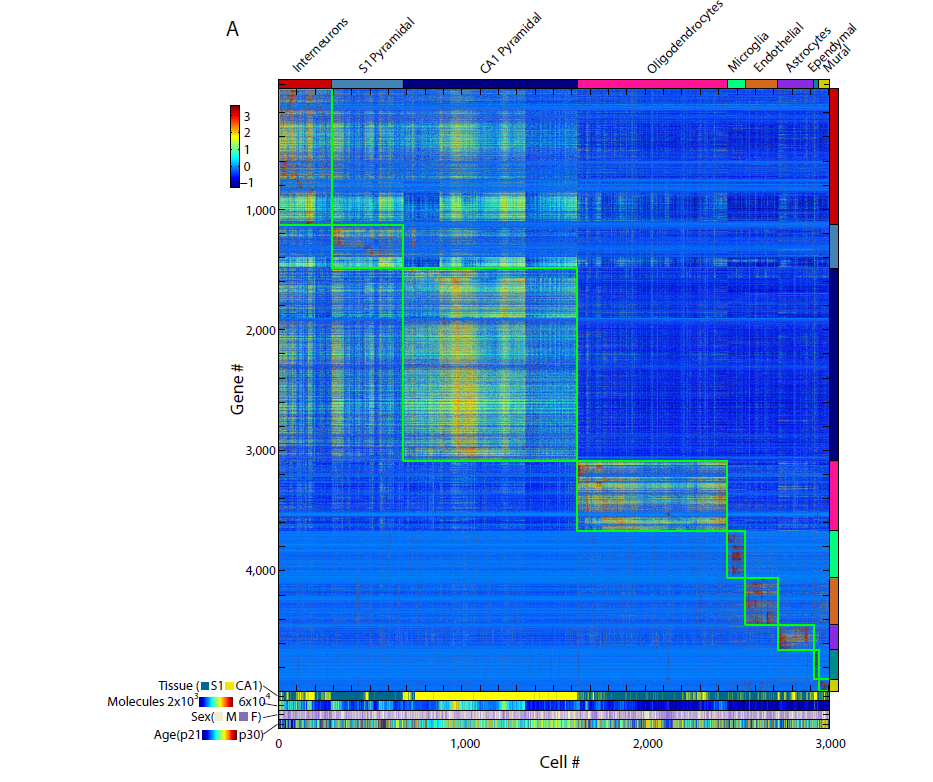

In [86]:
from IPython.display import Image
Image('Zeisel.png')

Generate spectral clustering labels for k=2 and k=9. Need to generate a distance matrix first, and we chose to use Shannon-Jensen entropy for pairwise distances.

In [60]:
with open('/data/SS_RNA_seq/Code/pairwise_jensen_shannon_divergence.dat', 'rb') as infile:
    D = pickle.load(infile)
    
# Spectral clustering for k=2
labels_spectral_2, similarity_matrix_l1=jz_spectral(X,2,D)

# Spectral clustering for k=9
labels_spectral_9, similarity_matrix_l1=jz_spectral(X,9,D)

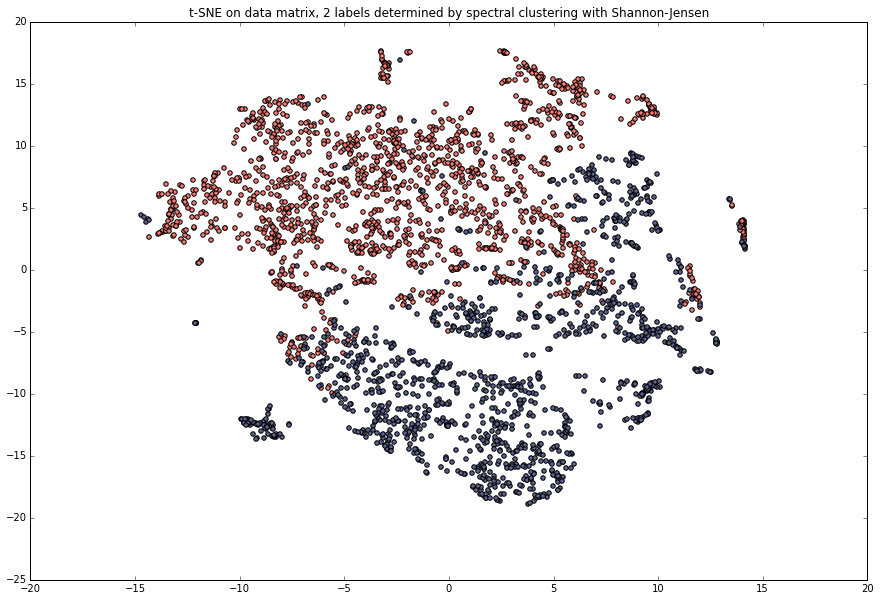

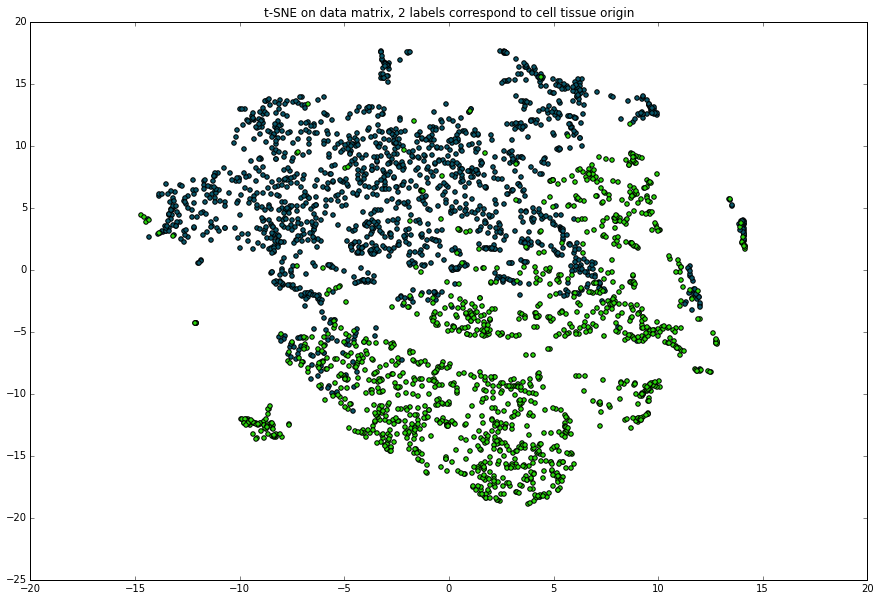

In [102]:
#Plot spectral clustering for 2 clusters

jz_plot(X_tsne,labels_spectral_2)
plt.title('t-SNE on data matrix, 2 labels determined by spectral clustering with Shannon-Jensen')
jz_plot(X_tsne,truth_ge4)
plt.title('t-SNE on data matrix, 2 labels correspond to cell tissue origin')

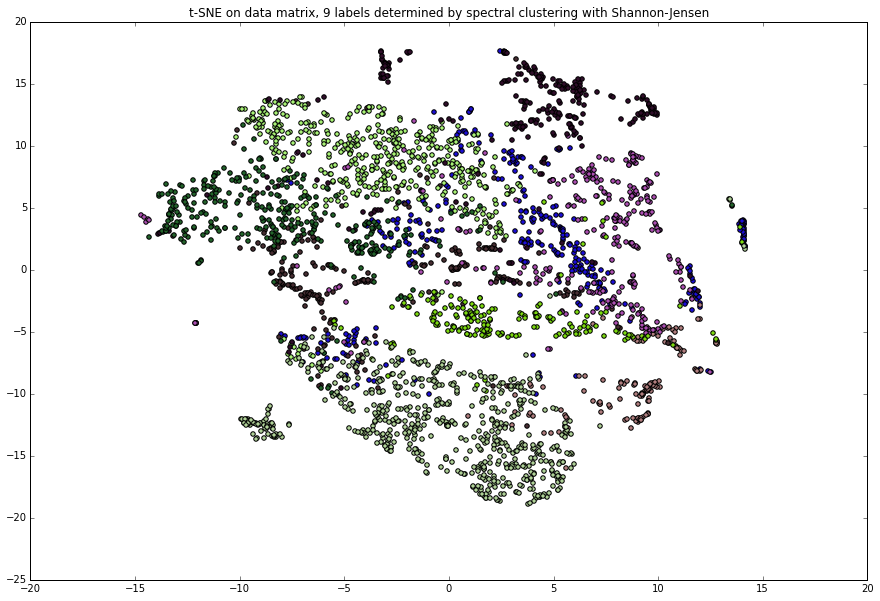

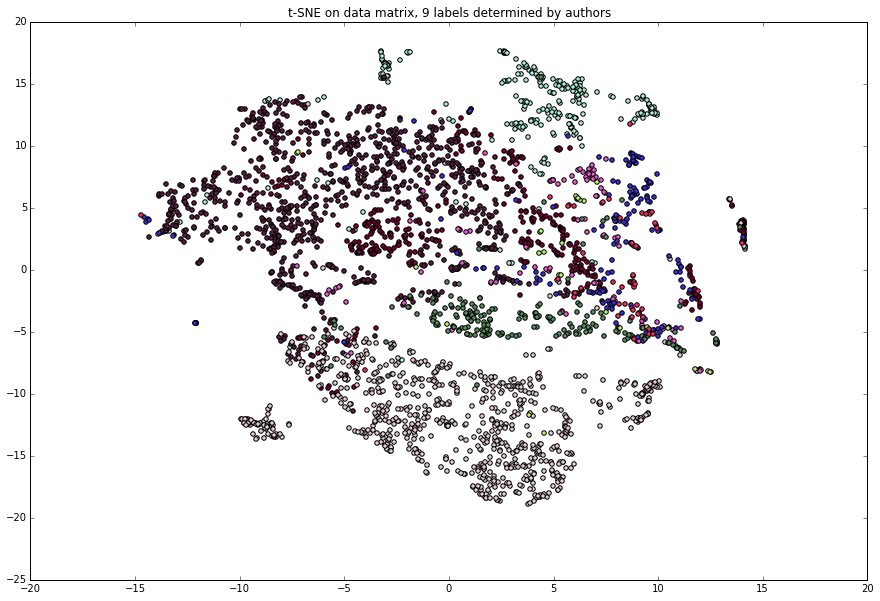

In [98]:
#Plot spectral clustering for 9 clusters

jz_plot(X_tsne,labels_spectral_9)
plt.title('t-SNE on data matrix, 9 labels determined by spectral clustering with Shannon-Jensen')
jz_plot(X_tsne,truth_9)
plt.title('t-SNE on data matrix, 9 labels determined by authors')

We now compute the error rates that the spectral clustering obtains when clustering classes 1,2, and 3 from classes 4 to 9. 

In [87]:
truth_ge4=np.zeros(truth_9.shape)
truth_ge4[truth_9>='4']=1

print str(compare_labels(truth_ge4,labels_spectral_2)/float(3005)*100)+"%"

2.26289517471%


We next repeat the entire experiment using total-variation distance rather than Jensen-Shannon distances.

In [91]:
with open('/data/SS_RNA_seq/Code/pairwise_manhattan_distances.dat', 'rb') as infile:
    Dl1 = pickle.load(infile)
    
# Spectral clustering for k=2
labels_spectral_l1_2, similarity_matrix_l1=jz_spectral(X,2,Dl1)

# Spectral clustering for k=9
labels_spectral_l1_9, similarity_matrix_l1=jz_spectral(X,9,Dl1)

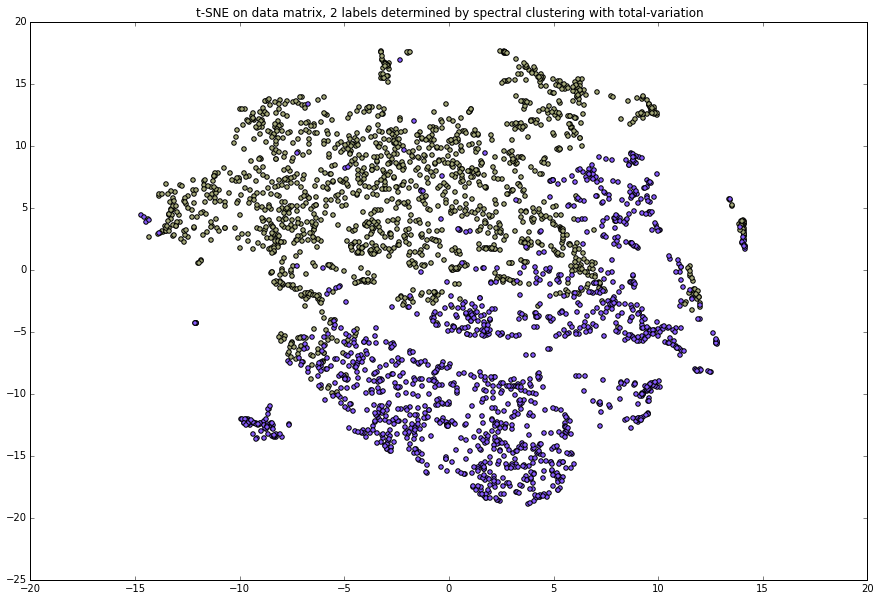

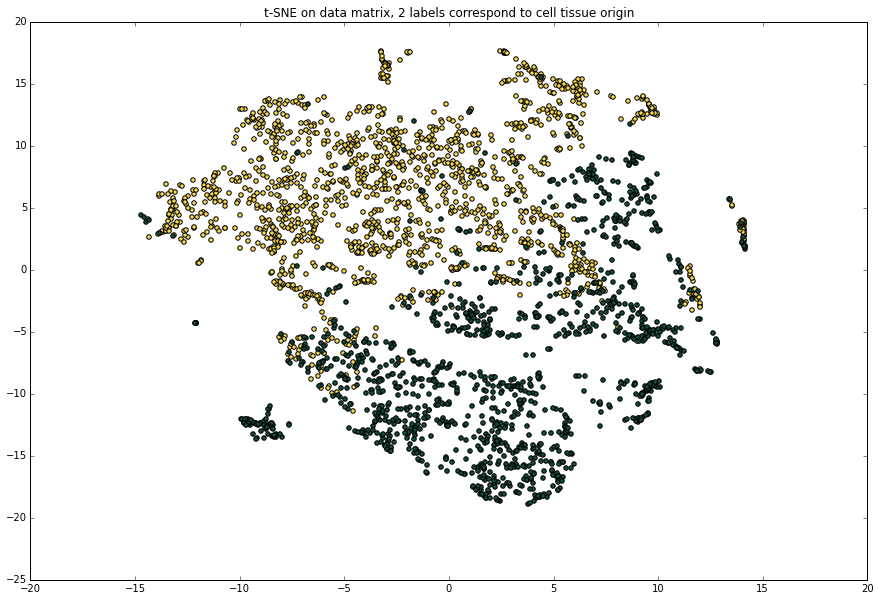

In [105]:
#Plot spectral clustering for 2 clusters

jz_plot(X_tsne,labels_spectral_l1_2)
plt.title('t-SNE on data matrix, 2 labels determined by spectral clustering with total-variation')
jz_plot(X_tsne,truth_ge4)
plt.title('t-SNE on data matrix, 2 labels correspond to cell tissue origin')

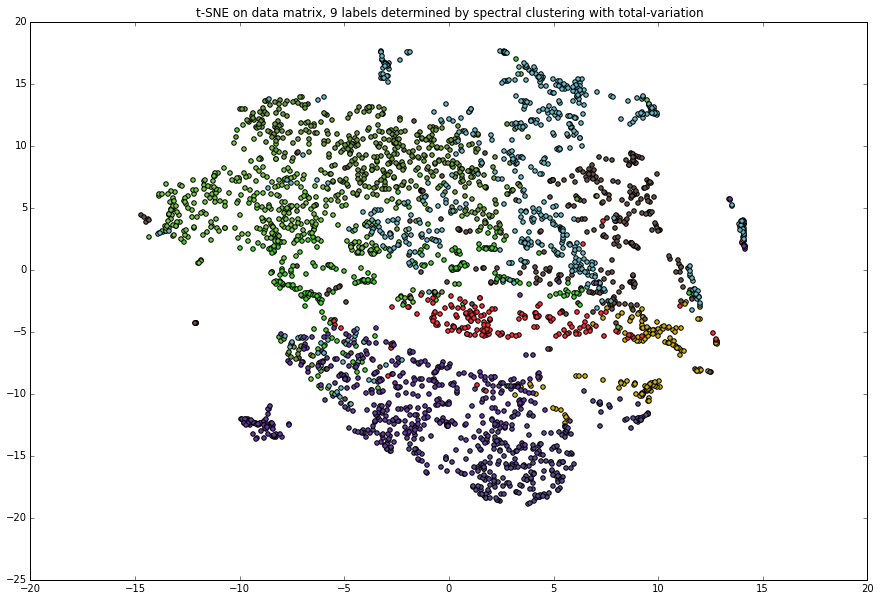

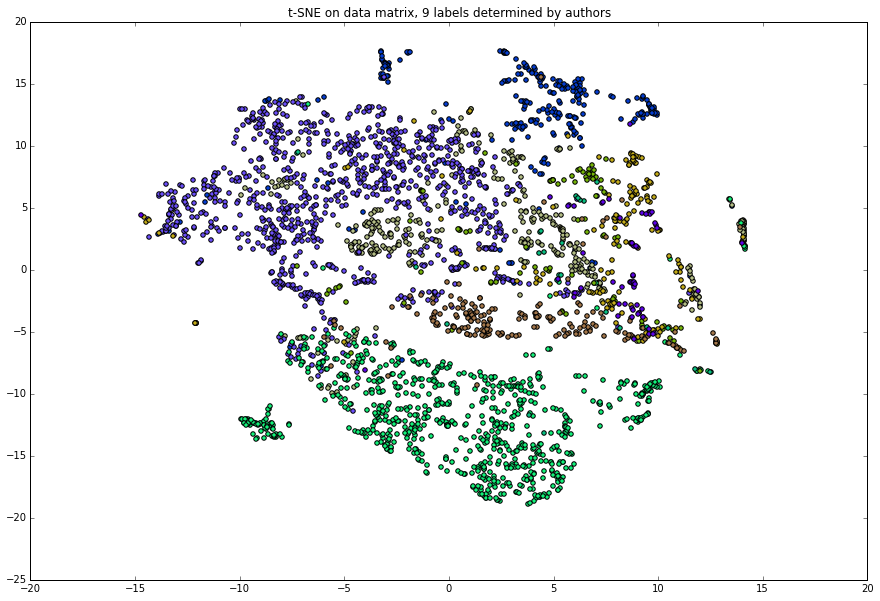

In [94]:
#Plot spectral clustering for 9 clusters

jz_plot(X_tsne,labels_spectral_l1_9)
plt.title('t-SNE on data matrix, 9 labels determined by spectral clustering with total-variation')
jz_plot(X_tsne,truth_9)
plt.title('t-SNE on data matrix, 9 labels determined by authors')

We now compute the error rates that the spectral clustering obtains when clustering classes 1,2, and 3 from classes 4 to 9.

In [96]:
print str(compare_labels(truth_ge4,labels_spectral_l1_2)/float(3005)*100)+"%"

2.12978369384%
